In [8]:
import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from sod.evaluation.datasets import oneminutewindows

dataframe = oneminutewindows(os.path.join(os.getcwd(), '..', '..', 'tmp', 'datasets', 'oneminutewindows.hdf'), normalize_=True)

predictions = pd.read_hdf(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                                      'OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.evalpredictions.hdf'))

print('predictions: %d' % len(predictions))
predictions['modified'] = predictions['modified'].astype('category')


clf50 = load(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                       'OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.model'))
clf10 = load(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                       'OneClassSVM?features=psd@2sec,psd@5sec&gamma=10&kernel=rbf&nu=0.1&cache_size=1500.model'))


Opening /Users/riccardo/work/gfz/projects/sources/python/sod/tmp/datasets/oneminutewindows.hdf

                                instances
ok                              1,003,203
outl. (wrong inv. file)             4,356
outl. (cha. resp. acc <-> vel)  1,181,439
outl. (gain X100 or X0.01)      1,003,203
outl. (gain X10 or X0.1)        1,003,203
outl. (gain X2 or X0.5)         1,003,203
total                           5,198,607

Normalizing numeric columns (floats only)
(only good instances - no outliers - taken into account)
                  min median   max      NAs ids outside[1-99]%
psd@0.05sec      0.00   0.97  1.13    2,652             10,647
psd@0.1sec       0.00   0.97  1.12        0             10,890
psd@0.2sec       0.00   0.97  1.10        4             10,938
psd@0.5sec       0.00   0.97  1.10       16             11,261
psd@1sec         0.00   0.97  1.10       40             11,464
psd@2sec         0.00   0.97  1.09      106             10,982
psd@3sec         0.00   0.9

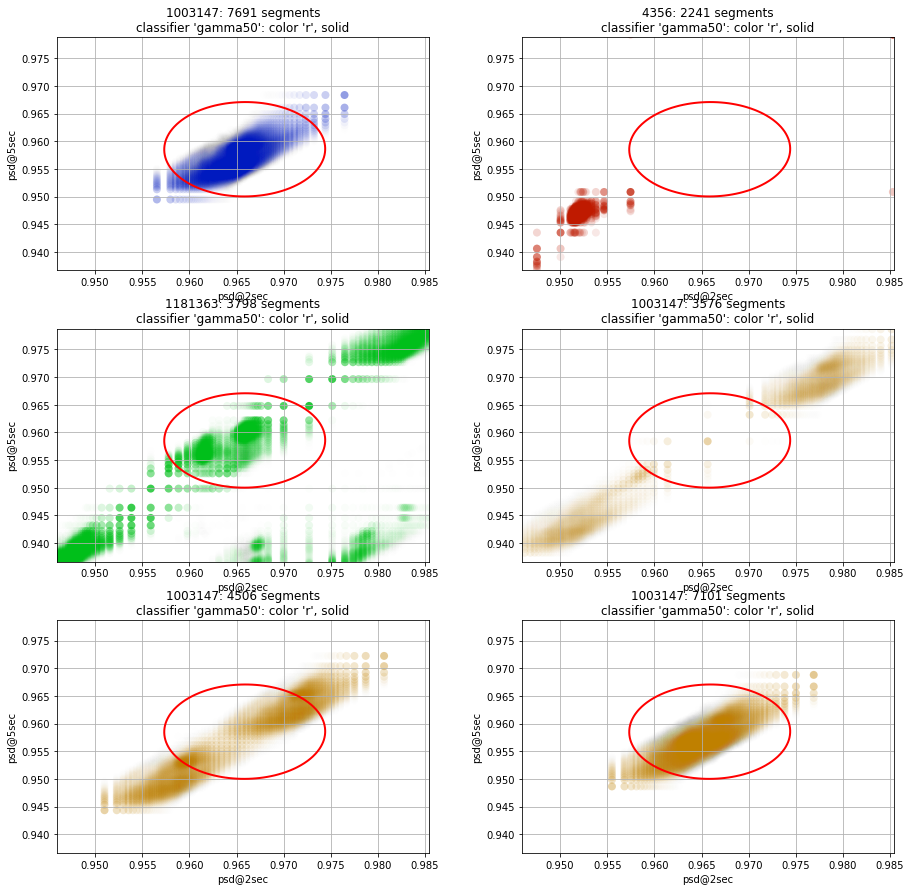

In [30]:
import importlib
import sod.plot as sod_plot
importlib.reload(sod_plot)

%matplotlib inline

fig = sod_plot.plot(dataframe, 'psd@2sec', 'psd@5sec', axis_lim=0.97, clfs={'gamma50': clf50}) 

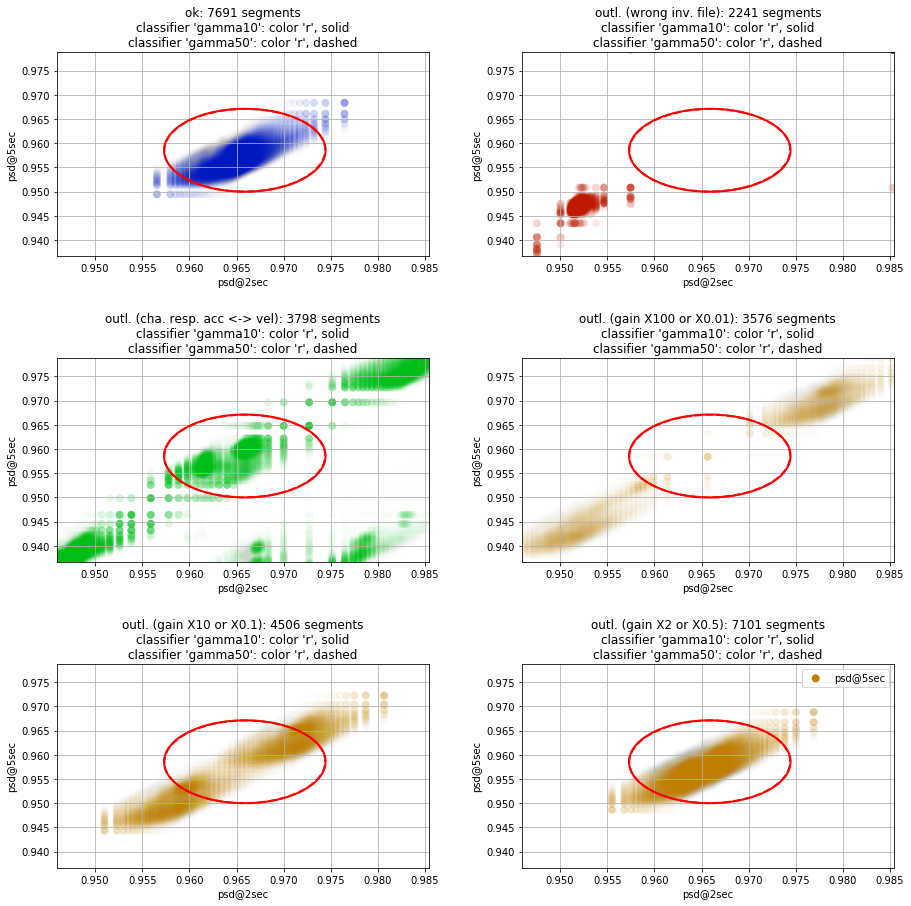

In [27]:
fig = sod_plot.plot(dataframe, 'psd@2sec', 'psd@5sec', axis_lim=0.97, clfs={'gamma10': clf10, 'gamma50': clf50}) 

In [11]:
print(str(clf50))
print(clf50.support_vectors_)

OneClassSVM(cache_size=1500, coef0=0.0, degree=3, gamma=50, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)
[[0.95658065 0.94482111]
 [0.9562857  0.94520046]
 [0.95636838 0.9448346 ]
 ...
 [0.95794726 0.95295959]
 [0.96034659 0.95191952]
 [0.96032469 0.95183555]]


In [12]:
print(str(clf10))
print(clf10.support_vectors_)

OneClassSVM(cache_size=1500, coef0=0.0, degree=3, gamma=10, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)
[[0.95658065 0.94482111]
 [0.9562857  0.94520046]
 [0.95636838 0.9448346 ]
 ...
 [0.95794726 0.95295959]
 [0.96034659 0.95191952]
 [0.96032469 0.95183555]]


In [13]:
(clf10.support_vectors_ == clf50.support_vectors_).all()

False

In [15]:
clf10.support_vectors_[clf10.support_vectors_ != clf50.support_vectors_]

array([0.95988614, 0.95242531, 0.97544526, ..., 0.96331431, 0.95969826,
       0.95261706])

In [16]:
clf50.support_vectors_[clf10.support_vectors_ != clf50.support_vectors_]

array([0.97544526, 0.96510413, 0.95787776, ..., 0.96297347, 0.97448256,
       0.96331431])

In [17]:
len(clf10.support_vectors_)

93708

In [22]:
clf50.decision_function([[.96, .964], [.96, .965]])

array([ 37.86506508, -17.23445849])

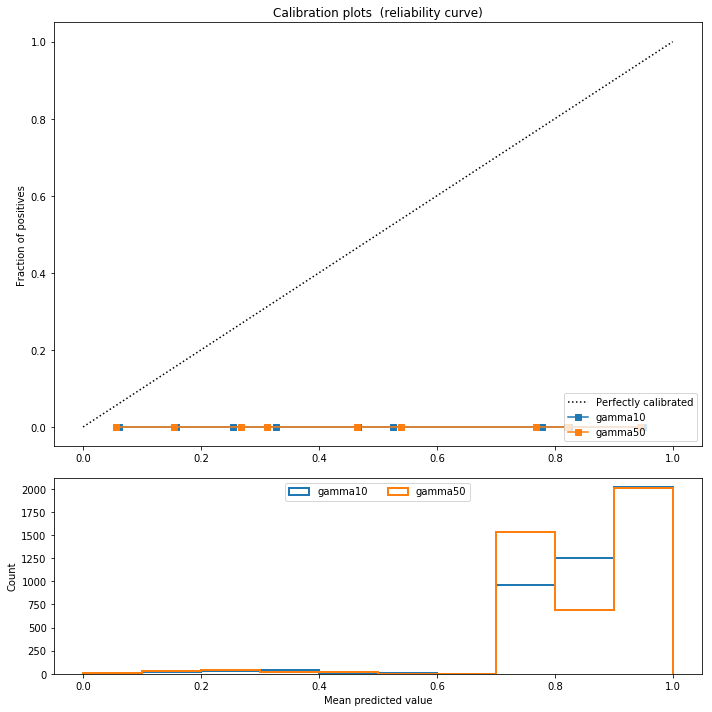

In [15]:
import importlib
import sod.plot as sod_plot
importlib.reload(sod_plot)
from sod.evaluation import is_out_wrong_inv
sod_plot.plot_calibration_curve(
    {'gamma10': clf10, 'gamma50':clf50}, dataframe[is_out_wrong_inv(dataframe)], ['psd@2sec', 'psd@5sec'])

Automatically created module for IPython interactive environment
[0 1 1 ... 0 0 1]
[0.0113659  0.9579489  0.98878331 ... 0.20863386 0.57549257 0.82257062]


RuntimeError: No active exception to reraise

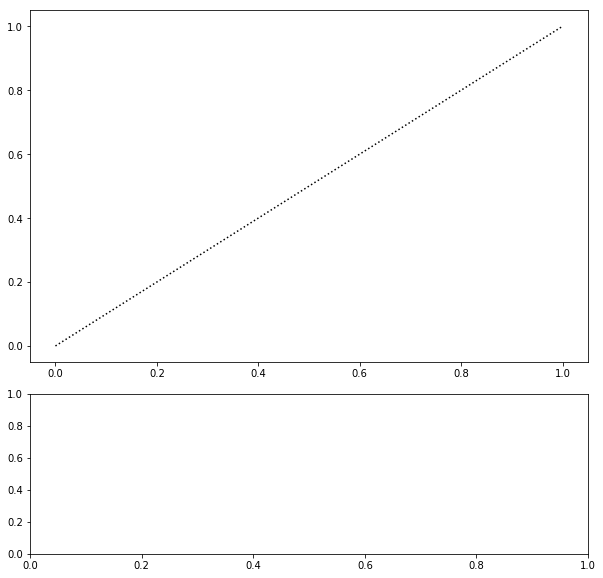

In [17]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
    print(y_test)
    print(prob_pos)
    raise

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()